In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import snowFun
import dask.array
from shapely.geometry import Point
# %matplotlib widget

# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_climate = os.path.join(folder_AGVA, "Climate")

In [2]:
# open rgi attribute table, subsetting to the columns we want
path_rgi = os.path.join(folder_AGVA, 'RGI', "01_rgi60_Alaska", "01_rgi60_Alaska.shp")
path_rgi = os.path.join(folder_AGVA, 'RGI', "RGI_v70", "RGI2000-v7.0-G-01_alaska", "RGI2000-v7.0-G-01_alaska-attributes.csv")
rgi_df = pd.read_csv(path_rgi, usecols=["rgi_id","cenlon","cenlat","area_km2","zmed_m","zmean_m"])
# rgi_df.head()

In [3]:
# open the daily temp and precip data
path_t = os.path.join(folder_climate, "era5land_daily_temp_2018_2022.tif")
path_p = os.path.join(folder_climate, "era5land_daily_precip_2018_2022.tif")
path_z = os.path.join(folder_climate, "geo_1279l4_0.1x0.1.grib2_v4_unpack.nc")

t_xr = riox.open_rasterio(path_t).rename({'band':'time'})
p_xr = riox.open_rasterio(path_p).rename({'band':'time'})
print(t_xr.head)

min(t_xr.x.values)

<bound method DataArray.head of <xarray.DataArray (time: 1826, y: 120, x: 478)>
[104739360 values with dtype=float64]
Coordinates:
  * time         (time) int32 1 2 3 4 5 6 7 ... 1821 1822 1823 1824 1825 1826
  * x            (x) float64 -176.2 -176.1 -176.0 ... -128.7 -128.6 -128.5
  * y            (y) float64 63.9 63.8 63.7 63.6 63.5 ... 52.3 52.2 52.1 52.0
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0>


-176.2

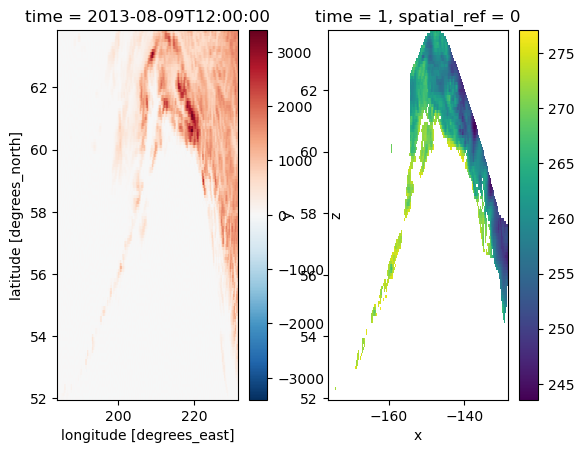

In [4]:
# open geopotential product
z_xr = xr.open_dataset(path_z).z

# convert to geopotential height
z_xr = z_xr/9.80665

# adjust longitude values
# z_xr['longitude'] = z_xr['longitude']-360

# subset to the aoi
z_xr = z_xr.sel( longitude=slice(min(t_xr.x.values)+360, max(t_xr.x.values)+360), latitude=slice(max(t_xr.y.values), min(t_xr.y.values)) )

# resave
z_xr.to_netcdf(path=os.path.join(folder_climate, "orography.nc"))
z_xr.rio.to_raster(raster_path=os.path.join(folder_climate, "orography.tif"))

fig, axs = plt.subplots(1,2)
z_xr.plot(ax=axs[0])
t_xr.sel(time=1).plot(ax=axs[1])

In [5]:
# create list of dates
dates = pd.date_range(start="2018-01-01", end='2022-12-31', freq='D')
print(len(dates), len(t_xr.time))

t_xr['time']=dates
p_xr['time']=dates


1826 1826


In [8]:
# for each rgi (greater than 2km2), extract daily climate data at that lat/lon, save to csv
c=0
n=len(rgi_df[rgi_df['area_km2']>=2])
for idx, row in rgi_df[rgi_df['area_km2']>=2].iterrows():
    c+=1
    print(f"{c} of {n}")
#     if c>0:continue
        
    rgi_id = row['rgi_id']
    cenlon = row['cenlon']
    cenlat = row['cenlat']
    z_med = row["zmed_m"]
    
    temps = t_xr.sel(x=cenlon, y=cenlat, method="nearest")
    precips = p_xr.sel(x=cenlon, y=cenlat, method="nearest")
    z = z_xr.sel(longitude=cenlon+360, latitude=cenlat, method='nearest').values[0]
#     print(z)
    
    out_df = pd.DataFrame({'rgi_id':rgi_id,'date':dates,'t':temps,'p':precips, 'z_era5land':z, "zmed_m":z_med})
    out_path = os.path.join(folder_climate, "csv", 'daily', f'{rgi_id}.csv')
    
    out_df.to_csv(out_path, index='False')

1 of 3056
2 of 3056
3 of 3056
4 of 3056
5 of 3056
6 of 3056
7 of 3056
8 of 3056
9 of 3056
10 of 3056
11 of 3056
12 of 3056
13 of 3056
14 of 3056
15 of 3056
16 of 3056
17 of 3056
18 of 3056
19 of 3056
20 of 3056
21 of 3056
22 of 3056
23 of 3056
24 of 3056
25 of 3056
26 of 3056
27 of 3056
28 of 3056
29 of 3056
30 of 3056
31 of 3056
32 of 3056
33 of 3056
34 of 3056
35 of 3056
36 of 3056
37 of 3056
38 of 3056
39 of 3056
40 of 3056
41 of 3056
42 of 3056
43 of 3056
44 of 3056
45 of 3056
46 of 3056
47 of 3056
48 of 3056
49 of 3056
50 of 3056
51 of 3056
52 of 3056
53 of 3056
54 of 3056
55 of 3056
56 of 3056
57 of 3056
58 of 3056
59 of 3056
60 of 3056
61 of 3056
62 of 3056
63 of 3056
64 of 3056
65 of 3056
66 of 3056
67 of 3056
68 of 3056
69 of 3056
70 of 3056
71 of 3056
72 of 3056
73 of 3056
74 of 3056
75 of 3056
76 of 3056
77 of 3056
78 of 3056
79 of 3056
80 of 3056
81 of 3056
82 of 3056
83 of 3056
84 of 3056
85 of 3056
86 of 3056
87 of 3056
88 of 3056
89 of 3056
90 of 3056
91 of 3056
92 of 30

693 of 3056
694 of 3056
695 of 3056
696 of 3056
697 of 3056
698 of 3056
699 of 3056
700 of 3056
701 of 3056
702 of 3056
703 of 3056
704 of 3056
705 of 3056
706 of 3056
707 of 3056
708 of 3056
709 of 3056
710 of 3056
711 of 3056
712 of 3056
713 of 3056
714 of 3056
715 of 3056
716 of 3056
717 of 3056
718 of 3056
719 of 3056
720 of 3056
721 of 3056
722 of 3056
723 of 3056
724 of 3056
725 of 3056
726 of 3056
727 of 3056
728 of 3056
729 of 3056
730 of 3056
731 of 3056
732 of 3056
733 of 3056
734 of 3056
735 of 3056
736 of 3056
737 of 3056
738 of 3056
739 of 3056
740 of 3056
741 of 3056
742 of 3056
743 of 3056
744 of 3056
745 of 3056
746 of 3056
747 of 3056
748 of 3056
749 of 3056
750 of 3056
751 of 3056
752 of 3056
753 of 3056
754 of 3056
755 of 3056
756 of 3056
757 of 3056
758 of 3056
759 of 3056
760 of 3056
761 of 3056
762 of 3056
763 of 3056
764 of 3056
765 of 3056
766 of 3056
767 of 3056
768 of 3056
769 of 3056
770 of 3056
771 of 3056
772 of 3056
773 of 3056
774 of 3056
775 of 3056
776 

1347 of 3056
1348 of 3056
1349 of 3056
1350 of 3056
1351 of 3056
1352 of 3056
1353 of 3056
1354 of 3056
1355 of 3056
1356 of 3056
1357 of 3056
1358 of 3056
1359 of 3056
1360 of 3056
1361 of 3056
1362 of 3056
1363 of 3056
1364 of 3056
1365 of 3056
1366 of 3056
1367 of 3056
1368 of 3056
1369 of 3056
1370 of 3056
1371 of 3056
1372 of 3056
1373 of 3056
1374 of 3056
1375 of 3056
1376 of 3056
1377 of 3056
1378 of 3056
1379 of 3056
1380 of 3056
1381 of 3056
1382 of 3056
1383 of 3056
1384 of 3056
1385 of 3056
1386 of 3056
1387 of 3056
1388 of 3056
1389 of 3056
1390 of 3056
1391 of 3056
1392 of 3056
1393 of 3056
1394 of 3056
1395 of 3056
1396 of 3056
1397 of 3056
1398 of 3056
1399 of 3056
1400 of 3056
1401 of 3056
1402 of 3056
1403 of 3056
1404 of 3056
1405 of 3056
1406 of 3056
1407 of 3056
1408 of 3056
1409 of 3056
1410 of 3056
1411 of 3056
1412 of 3056
1413 of 3056
1414 of 3056
1415 of 3056
1416 of 3056
1417 of 3056
1418 of 3056
1419 of 3056
1420 of 3056
1421 of 3056
1422 of 3056
1423 of 3056

1978 of 3056
1979 of 3056
1980 of 3056
1981 of 3056
1982 of 3056
1983 of 3056
1984 of 3056
1985 of 3056
1986 of 3056
1987 of 3056
1988 of 3056
1989 of 3056
1990 of 3056
1991 of 3056
1992 of 3056
1993 of 3056
1994 of 3056
1995 of 3056
1996 of 3056
1997 of 3056
1998 of 3056
1999 of 3056
2000 of 3056
2001 of 3056
2002 of 3056
2003 of 3056
2004 of 3056
2005 of 3056
2006 of 3056
2007 of 3056
2008 of 3056
2009 of 3056
2010 of 3056
2011 of 3056
2012 of 3056
2013 of 3056
2014 of 3056
2015 of 3056
2016 of 3056
2017 of 3056
2018 of 3056
2019 of 3056
2020 of 3056
2021 of 3056
2022 of 3056
2023 of 3056
2024 of 3056
2025 of 3056
2026 of 3056
2027 of 3056
2028 of 3056
2029 of 3056
2030 of 3056
2031 of 3056
2032 of 3056
2033 of 3056
2034 of 3056
2035 of 3056
2036 of 3056
2037 of 3056
2038 of 3056
2039 of 3056
2040 of 3056
2041 of 3056
2042 of 3056
2043 of 3056
2044 of 3056
2045 of 3056
2046 of 3056
2047 of 3056
2048 of 3056
2049 of 3056
2050 of 3056
2051 of 3056
2052 of 3056
2053 of 3056
2054 of 3056

2609 of 3056
2610 of 3056
2611 of 3056
2612 of 3056
2613 of 3056
2614 of 3056
2615 of 3056
2616 of 3056
2617 of 3056
2618 of 3056
2619 of 3056
2620 of 3056
2621 of 3056
2622 of 3056
2623 of 3056
2624 of 3056
2625 of 3056
2626 of 3056
2627 of 3056
2628 of 3056
2629 of 3056
2630 of 3056
2631 of 3056
2632 of 3056
2633 of 3056
2634 of 3056
2635 of 3056
2636 of 3056
2637 of 3056
2638 of 3056
2639 of 3056
2640 of 3056
2641 of 3056
2642 of 3056
2643 of 3056
2644 of 3056
2645 of 3056
2646 of 3056
2647 of 3056
2648 of 3056
2649 of 3056
2650 of 3056
2651 of 3056
2652 of 3056
2653 of 3056
2654 of 3056
2655 of 3056
2656 of 3056
2657 of 3056
2658 of 3056
2659 of 3056
2660 of 3056
2661 of 3056
2662 of 3056
2663 of 3056
2664 of 3056
2665 of 3056
2666 of 3056
2667 of 3056
2668 of 3056
2669 of 3056
2670 of 3056
2671 of 3056
2672 of 3056
2673 of 3056
2674 of 3056
2675 of 3056
2676 of 3056
2677 of 3056
2678 of 3056
2679 of 3056
2680 of 3056
2681 of 3056
2682 of 3056
2683 of 3056
2684 of 3056
2685 of 3056